In [1]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(111) 

def _normalize_to_counts(p, N):
    p = np.asarray(p, dtype=float)
    p /= p.sum()
    counts = np.floor(p * N).astype(int)
    remainder = N - counts.sum()
    if remainder > 0:
        frac = (p * N) - np.floor(p * N)
        idx = np.argsort(frac)[::-1][:remainder]
        counts[idx] += 1
    return counts, p / p.sum()

def population_lognormal(K=100, mu=0.0, sigma=1.2, N=100_000):
    x = rng.lognormal(mean=mu, sigma=sigma, size=K)
    counts, p = _normalize_to_counts(x, N)
    return pd.DataFrame({
        "type": np.arange(1, K + 1),
        "prob": p,
        "abundance": counts
    }).sort_values("abundance", ascending=False).reset_index(drop=True)

In [3]:
%run -n ../src/simulation.py

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N = 150_000
K1, K2, K3 = 400, 200, 100

pop1 = population_lognormal(K=K1, mu=0.0, sigma=1.0, N=N)
pop2 = population_lognormal(K=K2, mu=0.0, sigma=1.0, N=N)

pops = pop1, pop2

In [5]:
from copia.data import to_copia_dataset

def sample_from_population(pop_df, n, rng):
    p = np.asarray(pop_df["prob"].values, dtype=float)
    p = p / p.sum()
    return rng.multinomial(n, p)

ns = n1, n2 = 500, 1000
s1 = to_copia_dataset(sample_from_population(pop1, n1, rng=rng), input_type="counts")
s2 = to_copia_dataset(sample_from_population(pop2, n2, rng=rng), input_type="counts")

In [6]:
r1, c1 = rarefaction_curve(s1)
r2, c2 = rarefaction_curve(s2)

In [7]:
reference_point = min(max(c) for c in (c1, c2))
reference_point

0.7984558826440717

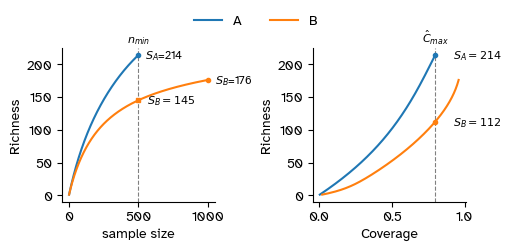

In [8]:
import matplotlib.pyplot as plt

plt.style.use('default')

p = plt.rcParams
p["font.sans-serif"] = ["Atkinson Hyperlegible"]
p["font.weight"] = "light"


fig, axes = plt.subplots(ncols=2, figsize=(5, 2.2), constrained_layout=True)
labels = "A", "B"

for i, r in enumerate((r1, r2)):
    axes[0].plot(np.arange(r.shape[0]), r, label=labels[i])
    axes[0].annotate(rf"$S_{{{labels[i]}}}$={int(max(r))}", xy=(r.shape[0] + 50, max(r)), va="center", fontsize=8)
    axes[0].plot([r.shape[0]], [max(r)], '.', color=f"C{i}")

offset = 50
axes[0].axvline(r1.shape[0], ls="--", color="grey", lw=0.8, zorder=-20)

reference_point = r1.shape[0]
axes[0].text(
    reference_point, 1.01, r"$n_{min}$",
    transform=axes[0].get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=8, color="black",
    clip_on=False
)

x0, y0 = reference_point, r2[reference_point]
x1 = x0 + offset
axes[0].plot([x0], [y0], 's', color=f"C{i}", markersize=3)

axes[0].annotate(
    f"$S_{{{labels[i]}}}={int(r2[reference_point])}$",
    xy=(x1, y0),
    xytext=(x1 + offset * 0.2, y0), 
    va="center",
    ha="left",
    fontsize=8,
)

axes[0].set(xlabel="sample size", ylabel="Richness")
fig.legend(loc="upper center", ncols=3, frameon=False, bbox_to_anchor=(0.5, 1.1))

offset = 0.1

reference_point = min(max(c) for c in (c1, c2))
for i, (r, c) in enumerate(((r1, c1), (r2, c2))):
    axes[1].plot(c, r)

    S = richness_at_coverage_argmin(r, c, reference_point)
    x0, y0 = reference_point, S
    x1 = x0 + offset  # shifted point for text placement
    # axes[1].plot([x0, x1], [y0, y0], ls="--", lw=0.8, color="gray")
    axes[1].plot([x0], [y0], '.', color=f"C{i}")

    axes[1].annotate(
        f"$S_{{{labels[i]}}}={int(S)}$",
        xy=(x1, y0),
        xytext=(x1 + offset * 0.2, y0),  # extra padding for text
        va="center",
        ha="left",
        fontsize=8,
    )

axes[1].set(xlabel="Coverage", ylabel="Richness")

axes[1].axvline(reference_point, ls="--", color="grey", lw=0.8, zorder=-20)
# Add label above it
axes[1].text(
    reference_point, 1.01, r"$\hat{C}_{max}$",
    transform=axes[1].get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=8, color="black",
    clip_on=False
)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.savefig("../images/example-graph-slim.png", dpi=300, bbox_inches='tight')